In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import datetime as dt
from merge_data_barpa import load_stn_info
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.dates as mdates

#For plotting soundings
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from metpy.calc import dewpoint_from_relative_humidity, dewpoint_from_specific_humidity
import glob
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as inset
from matplotlib.patches import Circle
import sharppy.plot.skew as skew
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import tqdm


In [2]:
#Read daily maximum wind gusts at each station, created by resample_daily_max.py

dmax_2p2km_point = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_2p2km.csv")
dmax_12km_point = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_12km.csv")
dmax_obs = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_obs.csv")
dmax_bdsd = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_bdsd.csv")

dmax_2p2km_point = dmax_2p2km_point.set_index(pd.to_datetime(dmax_2p2km_point.time))
dmax_12km_point = dmax_12km_point.set_index(pd.to_datetime(dmax_12km_point.time))
dmax_obs = dmax_obs.set_index(pd.to_datetime(dmax_obs.time))
dmax_bdsd = dmax_bdsd.set_index(pd.to_datetime(dmax_bdsd.time))

In [3]:
#Suspect gusts to drop - observations
obs_times = pd.to_datetime(dmax_obs.time)
dmax_obs.loc[(obs_times.dt.month == 12) & (obs_times.dt.year == 2010) & (dmax_obs.stn_id==55325) & (dmax_obs.gust >= 25),"gust"] = np.nan
dmax_obs.loc[dmax_obs.gust>=129, "gust"] = np.nan 


In [4]:
#Take the domain maximum for each day
dmax_2p2km_all = dmax_2p2km_point.sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_all = dmax_12km_point.sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_all = dmax_obs.dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_bdsd_all = dmax_bdsd.sort_values("bdsd_era5").drop_duplicates("dt_floor_1D",keep="last").sort_index()

In [5]:
#Take the domain maximum for each day using daily maximum observations at each station with lightning
dmax_2p2km_conv = dmax_2p2km_point.query("n_lightning_fl>=1").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_conv = dmax_12km_point.query("n_lightning_fl>=1").sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_conv = dmax_obs.query("Lightning_observed_daily>=1").dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()

#Take the domain maximum for each day using daily maximum observations at each station without lightning
dmax_2p2km_nonconv = dmax_2p2km_point.query("n_lightning_fl==0").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_nonconv = dmax_12km_point.query("n_lightning_fl==0").sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_nonconv = dmax_obs.query("Lightning_observed_daily==0").dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()


In [6]:
dmax_2p2km_conv.sort_values("wg10_2p2km_point",ascending=False)

,time,stn_id,wg10_2p2km_point,wgr_2p2km_point,n_lightning_fl,dt_floor_1D,bdsd,state,cluster,Umean06,lr13,qmean01,s06
time,,,,,,,,,,,,,
2015-01-03 04:00:00,2015-01-03 04:00:00,89112,43.177734,1.857257,211.0,2015-01-03,0.835938,vic,2,19.382812,8.851562,6.602539,12.421875
2007-12-31 06:20:00,2007-12-31 06:20:00,86371,39.357420,2.815573,849.0,2007-12-31,0.921875,vic,0,8.484375,9.672852,10.333984,10.937500
2009-12-17 04:30:00,2009-12-17 04:30:00,70339,39.353516,2.326685,396.0,2009-12-17,0.984375,nsw,2,21.695312,8.077148,8.552734,15.578125
2012-01-21 04:20:00,2012-01-21 04:20:00,58077,38.875000,1.372964,65726.0,2012-01-21,0.406250,nsw,0,16.312500,4.714844,15.851562,18.171875
2010-12-19 04:40:00,2010-12-19 04:40:00,72160,38.826170,3.007713,1204.0,2010-12-19,0.992188,nsw,2,19.398438,8.014648,7.284180,33.992188
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-02-10 07:10:00,2008-02-10 07:10:00,70339,10.579102,1.127010,10.0,2008-02-10,0.406250,nsw,0,5.406250,6.559570,8.454102,19.250000
2008-02-19 03:50:00,2008-02-19 03:50:00,53115,10.218750,1.027353,55.0,2008-02-19,0.171875,nsw,0,0.609375,6.283203,10.715820,17.070312
2010-02-19 02:40:00,2010-02-19 02:40:00,70217,10.183594,1.159367,257.0,2010-02-19,0.007812,nsw,0,3.109375,5.936523,9.292969,7.164062


In [7]:
barpac_2p2km = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_vic.csv")

In [8]:
def plot_barpac_timeseries(ax1,ax3,t,stn_id,y0=None,y1=None,t_drop=-2):

    
    ax2=ax1.twinx()
    y,x=load_stn_info("vic").query("stn_no=="+stn_id)[["lat","lon"]].values[0]    
    temp = barpac_2p2km.query("stn_id=="+stn_id)
    temp = temp.set_index(pd.to_datetime(temp["Unnamed: 1"]))
    temp = temp.loc[slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=+2))]
    ax1.plot(temp.index,temp["wg10_2p2km_point"].values,marker="o",color="k",label="Maximum wind gust\nin previous 10 minutes")
    ax1.set_ylim([y0,y1])
    ax1.set_title("BARPAC-M")
    
    scrn_temp = xr.open_mfdataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/era/erai/historical/r0/*/*/pp26/temp_scrn-pp26-BARPAC-M_km2p2-"+t.strftime("%Y%m")+"*.nc").\
                    sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=+2)))
            
    ax2.plot(temp.index,scrn_temp.sel(longitude=x,latitude=y,method="nearest").temp_scrn.values,
             marker="o",color="tab:blue",ls="--",label="Screen temperature")
    ax2.legend(loc=2)
    ax1.legend(loc=1)
    
    ax2.set_ylabel("Temperature (K)",color="tab:blue")
    ax1.set_ylabel("Wind gust (m/s)")
    ax2.tick_params(axis="y",labelcolor="tab:blue")
    ax2.grid(ls=":")
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    xr.open_mfdataset("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/era/erai/historical/r0/*/*/pp26/max_wndgust10m-pp26-BARPAC-M_km2p2-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=t,method="nearest").sel(longitude=slice(142.8, 146.49597),latitude=slice(-39.204285, -36.494324)).\
            max_wndgust10m.plot(ax=ax3,cmap=plt.get_cmap("Reds"))
    ax3.coastlines()

    ax3.plot(x,y,marker="x",color="tab:blue",ms=10,mew=2)   
    
#     xr.plot.contour(scrn_temp.diff("time",1,label="lower").sel(time=t).temp_scrn.sel(longitude=slice(142.8, 146.49597),latitude=slice(-39.204285, -36.494324)),
#                     ax=ax3,add_colorbar=False,levels=[t_drop])
    
    ax3.set_title(t)
    
# plt.figure(figsize=[12,5])
# scrn_temp=plot_barpac_timeseries(plt.subplot(1,2,1),plt.subplot(1,2,2,projection=ccrs.PlateCarree()),dt.datetime(2015,1,3,4,0),"89112",y0=None,y1=None)

In [9]:

        
def plot_sounding_barpa(time, lat, lon):

    barpa_str1 = time.strftime("%Y%m%d")
    barpa_str2 = (time - dt.timedelta(days=5)).strftime("%Y%m%d")    
    
    str_fmt = "/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/era/erai/historical/r0/*/%s*/%s/%s*.nc"
    # str_fmt = "/g/data/rt52/era5/pressure-levels/reanalysis/%s/%d/%s_era5_oper_pl_%s*.nc" 
    # str_fmt_sfc = "/g/data/rt52/era5/single-levels/reanalysis/%s/%d/%s_era5_oper_sfc_%s*.nc"
    
    z=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","geop_ht_uv")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","geop_ht_uv")))),
                        engine="netcdf4")["geop_ht_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")
    t=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","air_temp")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","air_temp")))),
                        engine="netcdf4")["air_temp_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    s=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","spec_hum")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","spec_hum")))),
                        engine="netcdf4")["spec_hum_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    u=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","wnd_ucmp")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","wnd_ucmp")))),
                        engine="netcdf4")["wnd_ucmp_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    v=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","wnd_vcmp")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","wnd_vcmp")))),
                        engine="netcdf4")["wnd_vcmp_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")

    ts=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp3","temp_scrn")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp3","temp_scrn")))),
                        engine="netcdf4")["temp_scrn"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    dps=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp26","dewpt_scrn")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp26","dewpt_scrn")))),
                        engine="netcdf4")["dewpt_scrn"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    us=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp3","uwnd10m_b")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp3","uwnd10m_b")))),
                        engine="netcdf4")["uwnd10m_b"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    vs=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp3","uwnd10m_b")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp3","uwnd10m_b")))),
                        engine="netcdf4")["uwnd10m_b"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")      
    ps=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp26","sfc_pres")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp26","sfc_pres")))),
                        engine="netcdf4")["sfc_pres"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")     
    zs=xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc").\
                        interp({"longitude":lon, "latitude":lat},method="nearest")["topog"]

    p=z.pressure
    dp=dewpoint_from_specific_humidity(p,t,s)
    prof_pres = np.flip(p.values.squeeze())
    prof_hgt = np.flip(z.values.squeeze())
    prof_tmpc = np.flip(t.values.squeeze()-273.15)
    prof_dwpc = np.flip(np.array(dp).squeeze())
    prof_u = np.flip(u.values.squeeze()*1.94)
    prof_v = np.flip(v.values.squeeze()*1.94)
    agl_inds = prof_pres <= (ps.values/100.)
    prof = profile.create_profile(pres=np.insert(prof_pres[agl_inds], 0, ps.values/100.),
                                  hght=np.insert(prof_hgt[agl_inds], 0, zs.values),
                                  tmpc=np.insert(prof_tmpc[agl_inds], 0, ts.values-273.15),
                                  dwpc=np.insert(prof_dwpc[agl_inds], 0, dps.values-273.15),
                                  u=np.insert(prof_u[agl_inds], 0, us.values*1.94),
                              v=np.insert(prof_v[agl_inds], 0, vs.values*1.94))
    sfcpcl = params.parcelx( prof, flag=1 )
    mupcl = params.parcelx( prof, flag=3 )
    mlpcl = params.parcelx( prof, flag=4 )   
    return prof, mupcl

def plot_sounding_era5(time, lat, lon):

    str_fmt = "/g/data/rt52/era5/pressure-levels/reanalysis/%s/%d/%s_era5_oper_pl_%s*.nc" 
    str_fmt_sfc = "/g/data/rt52/era5/single-levels/reanalysis/%s/%d/%s_era5_oper_sfc_%s*.nc"
    
    z=xr.open_dataset(glob.glob(str_fmt % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    t=xr.open_dataset(glob.glob(str_fmt % ("t",time.year,"t",time.strftime("%Y%m01")))[0])["t"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    r=xr.open_dataset(glob.glob(str_fmt % ("r",time.year,"r",time.strftime("%Y%m01")))[0])["r"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    u=xr.open_dataset(glob.glob(str_fmt % ("u",time.year,"u",time.strftime("%Y%m01")))[0])["u"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    v=xr.open_dataset(glob.glob(str_fmt % ("v",time.year,"v",time.strftime("%Y%m01")))[0])["v"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")

    ts=xr.open_dataset(glob.glob(str_fmt_sfc % ("2t",time.year,"2t",time.strftime("%Y%m01")))[0])["t2m"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    dps=xr.open_dataset(glob.glob(str_fmt_sfc % ("2d",time.year,"2d",time.strftime("%Y%m01")))[0])["d2m"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    us=xr.open_dataset(glob.glob(str_fmt_sfc % ("10u",time.year,"10u",time.strftime("%Y%m01")))[0])["u10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    vs=xr.open_dataset(glob.glob(str_fmt_sfc % ("10v",time.year,"10v",time.strftime("%Y%m01")))[0])["v10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    ps=xr.open_dataset(glob.glob(str_fmt_sfc % ("sp",time.year,"sp",time.strftime("%Y%m01")))[0])["sp"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    zs=xr.open_dataset(glob.glob(str_fmt_sfc % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")   
    
    p=z.level
    dp=dewpoint_from_relative_humidity(t,r)
    prof_pres = np.flip(p.values.squeeze())
    prof_hgt = np.flip(z.values.squeeze()/9.8)
    prof_tmpc = np.flip(t.values.squeeze()-273.15)
    prof_dwpc = np.flip(np.array(dp).squeeze())
    prof_u = np.flip(u.values.squeeze()*1.94)
    prof_v = np.flip(v.values.squeeze()*1.94)
    agl_inds = prof_pres <= (ps.values/100.)
    prof = profile.create_profile(pres=np.insert(prof_pres[agl_inds], 0, ps.values/100.),
                                  hght=np.insert(prof_hgt[agl_inds], 0, zs.values/9.8),
                                  tmpc=np.insert(prof_tmpc[agl_inds], 0, ts.values-273.15),
                                  dwpc=np.insert(prof_dwpc[agl_inds], 0, dps.values-273.15),
                                  u=np.insert(prof_u[agl_inds], 0, us.values*1.94),
                                  v=np.insert(prof_v[agl_inds], 0, vs.values*1.94))
    sfcpcl = params.parcelx( prof, flag=1 )
    mupcl = params.parcelx( prof, flag=3 )
    mlpcl = params.parcelx( prof, flag=4 )    

    return prof, mupcl

def plot_prof(prof, ax, ax2, gs, hodo_size=1.7):
        pb_plot=1050
        pt_plot=100
        dp_plot=10
        plevs_plot = np.arange(pb_plot,pt_plot-1,-dp_plot)

        # Set up the figure in matplotlib.
        ax.grid(True)
        plt.grid(True)      
        
        # Plot the background variables
        presvals = np.arange(1000, 0, -10)
        ax.semilogy(prof.vtmp[~prof.vtmp.mask], prof.pres[~prof.vtmp.mask], 'r', lw=2)
        #ax.semilogy(prof.tmpc[~prof.tmpc.mask], prof.pres[~prof.tmpc.mask], 'r', lw=2)
        ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)

        # Plot the parcel trace, but this may fail.  If it does so, inform the user.
        sfcpcl = params.parcelx( prof, flag=1 )
        mupcl = params.parcelx( prof, flag=3 )
        mlpcl = params.parcelx( prof, flag=4 )
        #ax.semilogy(sfcpcl.ttrace, sfcpcl.ptrace, 'k:')
        #ax.semilogy(mlpcl.ttrace, mlpcl.ptrace, color='tab:blue', ls=":")
        ax.semilogy(mupcl.ttrace, mupcl.ptrace, color='tab:red', ls=":")

        # Disables the log-formatting that comes with semilogy
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_yticks(np.linspace(100,1000,10))
        ax.set_ylim(1050,100)
        # [ax.text(-0.6, p, str(round(h/1000,1)) + " km", transform=ax.get_yaxis_transform(), va="center", size="x-large") 
        #      for h, p in zip(prof.hght[prof.pres >= 100][3:-1:2], prof.pres[prof.pres >= 100][3:-1:2])]

        # Plot the hodograph data.
        inset_axes = inset(ax,width=hodo_size, # width = 30% of parent_bbox
                                            height=hodo_size, # height : 1 inch
                                            loc=1)
        inset_axes.get_xaxis().set_visible(False)
        inset_axes.get_yaxis().set_visible(False)

        # Draw the range rings around the hodograph.
        for i in range(10,90,10):
            circle = Circle((0,0),i,color='k',alpha=.3, fill=False)
            if i % 10 == 0 and i <= 50:
                inset_axes.text(-i,2,str(i), fontsize=8, horizontalalignment='center')
            inset_axes.add_artist(circle)
        inset_axes.set_xlim(-60,60)
        inset_axes.set_ylim(-60,60)
        inset_axes.axhline(y=0, color='k')
        inset_axes.axvline(x=0, color='k')
        #srwind = tab.params.bunkers_storm_motion(prof)        
        skew.plotHodo(inset_axes, prof.hght, (prof.u), (prof.v), color='r')
        inset_axes.set_xlim([-50,60])
        inset_axes.set_ylim([-50,60])        

        # Draw the wind barbs axis and everything that comes with it.
        ax.set_xlim(-40,50)
        ax.set_xticks(np.arange(-40,60,10))
        skew.plot_wind_axes(ax2)
        skew.plot_wind_barbs(ax2, prof.pres, prof.u, prof.v)
        srwind = params.bunkers_storm_motion(prof)
        gs.update(left=0.05, bottom=0.05, top=0.95, right=1, wspace=0.025)       

        sfc = prof.pres[prof.sfc]
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        s06 = utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1] * 0.514444
        print("MUCAPE: ",mupcl.bplus, "MLCAPE: ",mlpcl.bplus, "SBCAPE: ",sfcpcl.bplus, "S06: ",s06, "DCAPE",params.dcape(prof)[0])        
        
def plot_radar(ax,t,stn_id):
    
    refl = xr.open_dataset("/g/data/rq0/level_2/2/COLUMNMAXREFLECTIVITY/2_"+\
                           dt.datetime.strptime(t,"%Y-%m-%d %H:%M").strftime("%Y%m%d")+"_columnmaxreflectivity.nc").sel(time=t,method="nearest")
    lon = refl.longitude.values
    lat = refl.latitude.values
    p=ax.pcolormesh(lon,lat,refl.columnmaxreflectivity,vmin=0,cmap=plt.get_cmap("Reds"))#,cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    ax.coastlines()
    cb=plt.colorbar(p)
    cb.set_label("Column maximum reflectivity (dBZ)")
    plt.title(t)
    print(lon.min(),lon.max())
    print(lat.min(),lat.max())
    
    y,x=load_stn_info("vic").query("stn_no=="+stn_id)[["lat","lon"]].values[0]    
    ax.plot(x,y,marker="x",color="tab:blue",ms=10,mew=2)   
    
def plot_obs_ts(ax,t,stn_id,y0=None,y1=None):

    aws = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/vic_one_min_gust/"+str(t.year)+".csv").query("stn_id=="+stn_id)
    aws.set_index(pd.to_datetime(aws.dt_utc)).loc[slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=+2))].resample("10Min").max().gust.\
                plot(color="k",marker="o",ax=ax,label="Maximum wind gust\nin previous 10 minutes")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Wind gust (m/s)")
    plt.legend()
    ax.set_ylim([y0,y1])
    ax.grid(ls=":")

def draw_gridlines(ax):
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER         
            

# Look at the three highest daily-domain maximum gusts in Victoria using convective gusts only
## Analysis is in terms of gust and temperature time series, as well as spatial gust pattern

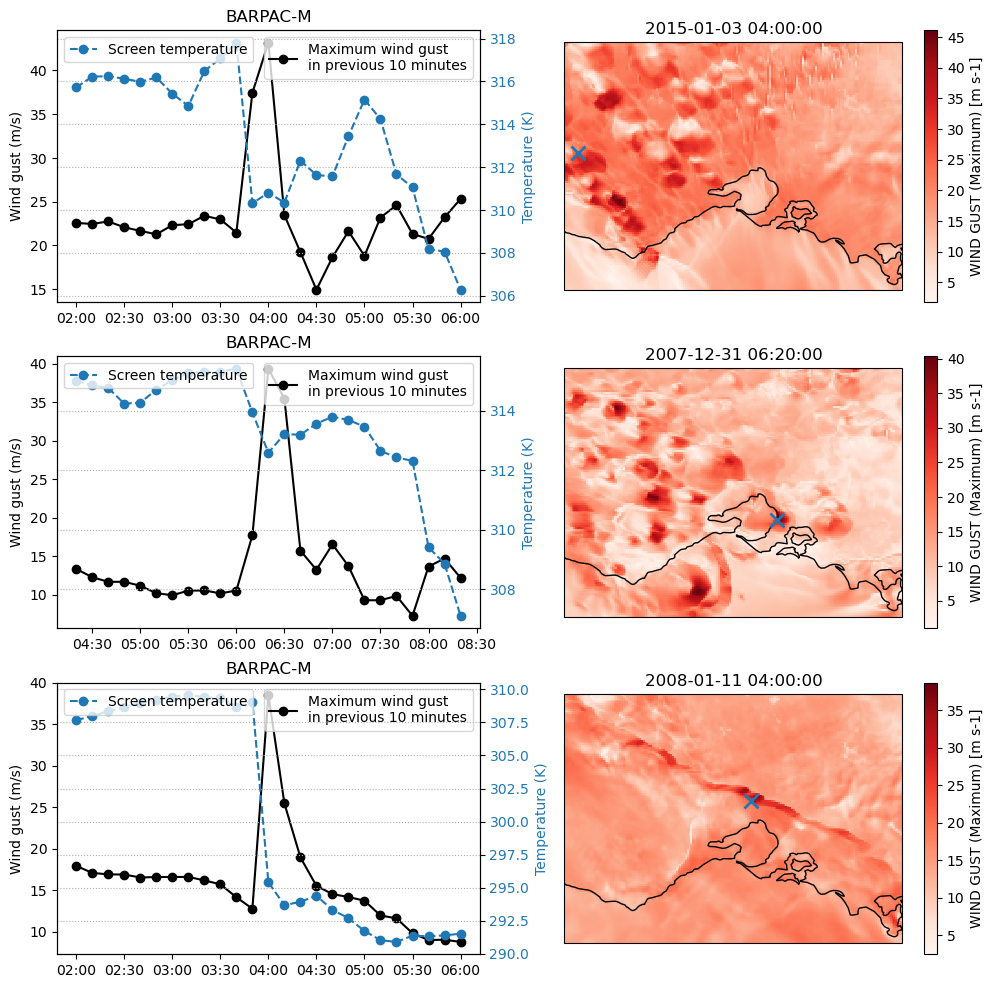

In [10]:
plt.figure(figsize=[12,12])        
r=3;c=2
plot_barpac_timeseries(plt.subplot(r,c,1),plt.subplot(r,c,2,projection=ccrs.PlateCarree()),dt.datetime(2015,1,3,4,0),"89112")
plot_barpac_timeseries(plt.subplot(r,c,3),plt.subplot(r,c,4,projection=ccrs.PlateCarree()),dt.datetime(2007,12,31,6,20),"86371")
plot_barpac_timeseries(plt.subplot(r,c,5),plt.subplot(r,c,6,projection=ccrs.PlateCarree()),dt.datetime(2008,1,11,4,0),"86395")
# plot_barpac_timeseries(plt.subplot(r,c,7),plt.subplot(r,c,8,projection=ccrs.PlateCarree()),dt.datetime(2012,12,18,23,50),"87168")
# plot_barpac_timeseries(plt.subplot(r,c,9),plt.subplot(r,c,10,projection=ccrs.PlateCarree()),dt.datetime(2013,12,19,3,30),"77094")

# Now perform similar analysis but compare with analogues from observations

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


MUCAPE:  751.2751242305828 MLCAPE:  35.14051978944199 SBCAPE:  751.2751242305828 S06:  11.293182129930944 DCAPE 1412.197385397247
144.8322 -37.6654


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/metpy/calc/thermo.py:1384: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


MUCAPE:  1644.7205970629714 MLCAPE:  1332.9431426508002 SBCAPE:  1644.7205970629714 S06:  17.018905984323737 DCAPE 555.1387753551048
143.01501 146.49597
-39.204285 -36.494324


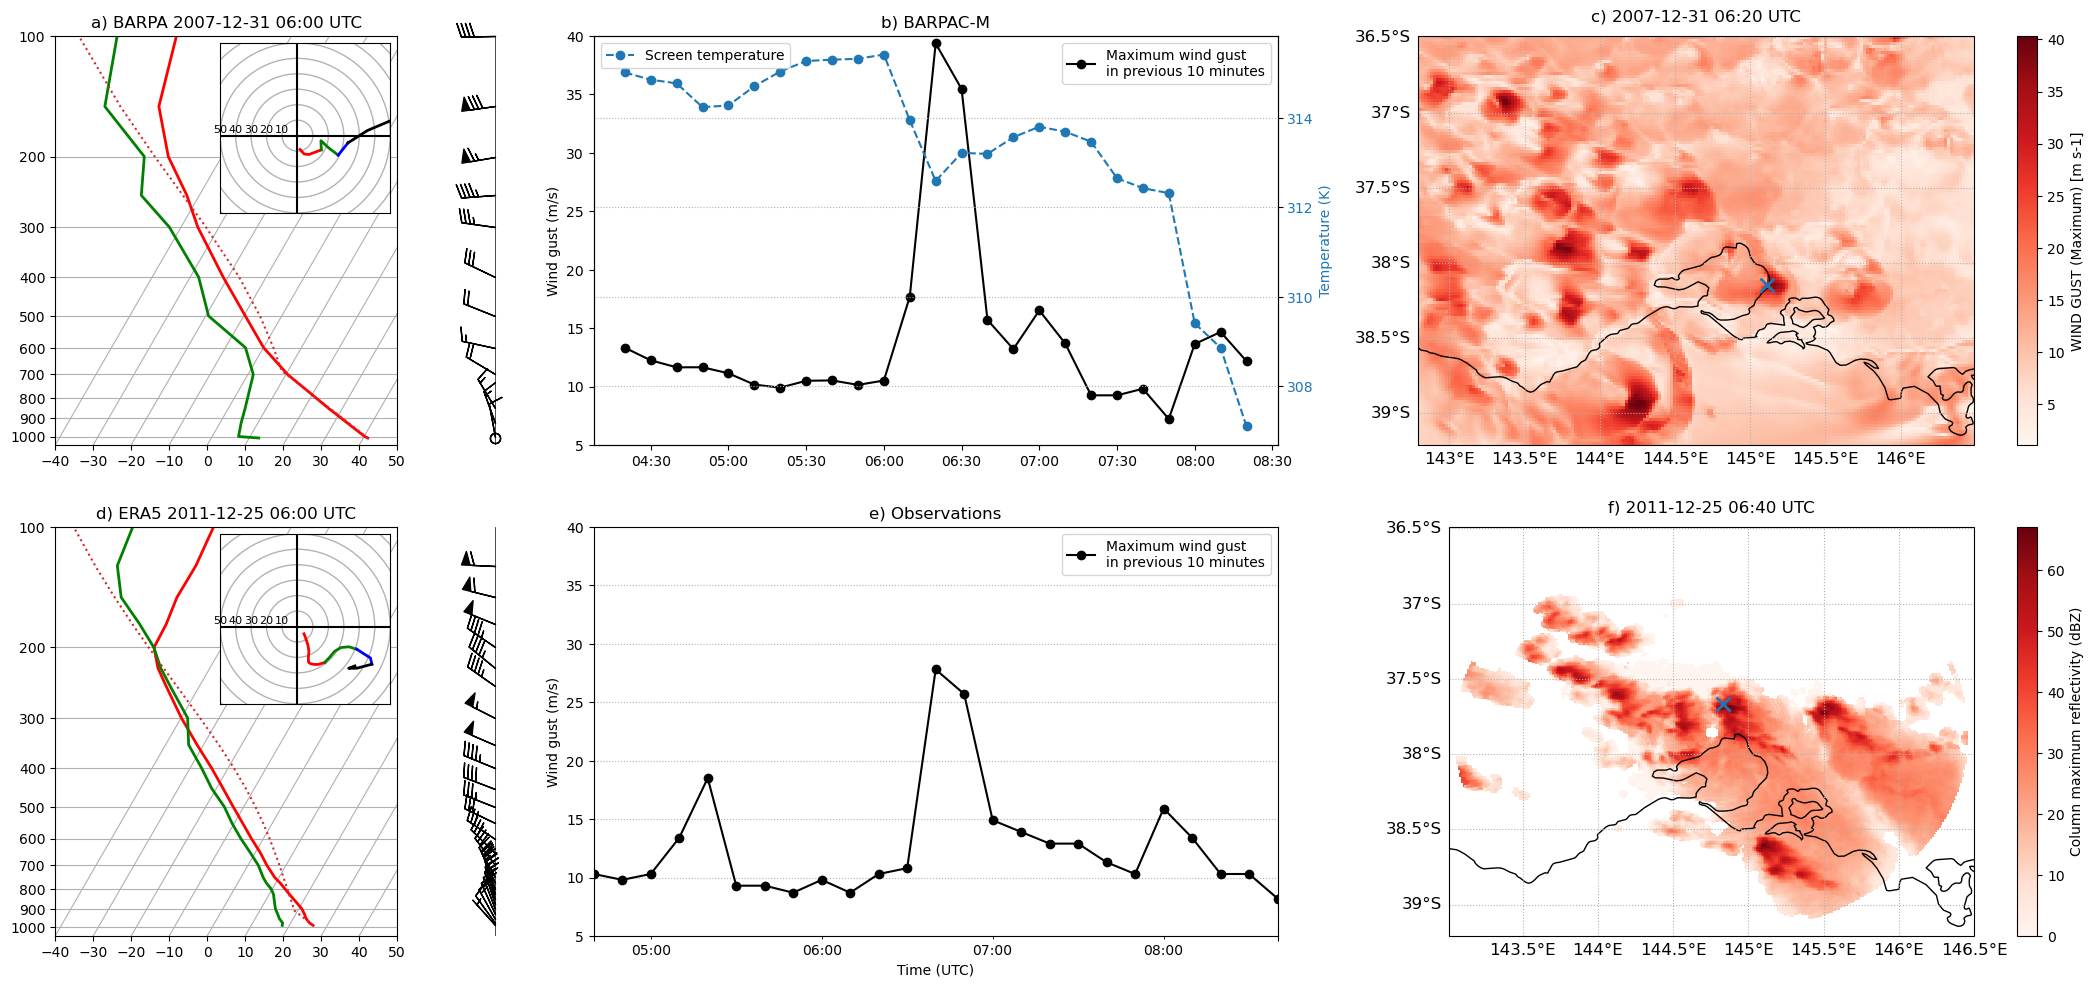

In [11]:
fig=plt.figure(figsize=[22,10])

#Plot the first cases
gs = fig.add_gridspec(2,4, width_ratios=[2,1,4,5])

#From BARPA
y,x=load_stn_info("vic").query("stn_no=="+"86371")[["lat","lon"]].values[0]  
prof, mu_pcl = plot_sounding_barpa(dt.datetime(2007,12,31,6,0),y,x)
ax = plt.subplot(gs[0, 0],projection='skewx')
ax2 = plt.subplot(gs[0, 1])
plot_prof(prof, ax, ax2, gs)
ax.set_title("a) BARPA 2007-12-31 06:00 UTC")

ax3=plt.subplot(gs[0, 2])
ax4=plt.subplot(gs[0, 3],projection=ccrs.PlateCarree())
plot_barpac_timeseries(ax3,ax4,dt.datetime(2007,12,31,6,20),"86371",y0=5,y1=40)
draw_gridlines(ax4)
ax3.set_title("b) BARPAC-M")
ax4.set_title("c) 2007-12-31 06:20 UTC")

#From ERA5
y,x=load_stn_info("vic").query("stn_no=="+"86282")[["lat","lon"]].values[0]  
print(x,y)
prof, mu_pcl = plot_sounding_era5(dt.datetime(2011,12,25,6,0),y,x)  
ax = plt.subplot(gs[1, 0],projection='skewx')
ax2 = plt.subplot(gs[1, 1])
plot_prof(prof, ax, ax2, gs)
ax.set_title("d) ERA5 2011-12-25 06:00 UTC")


plot_obs_ts(plt.subplot(gs[1, 2]),dt.datetime(2011,12,25,6,40),"86282",y0=5,y1=40); plt.title("e) Observations")
ax5=plt.subplot(gs[1, 3],projection=ccrs.PlateCarree())
plot_radar(ax5,"2011-12-25 06:40","86282")
draw_gridlines(ax5)
ax5.set_title("f) 2011-12-25 06:40 UTC")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/barpac_case_20071231.jpeg",dpi=400,bbox_inches="tight")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in exp
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in exp
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
 

MUCAPE:  126.53366764386811 MLCAPE:  0.0 SBCAPE:  126.53366764386811 S06:  15.675330790555554 DCAPE 1798.2712078998884
143.7924 -38.2332


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


MUCAPE:  100.20582973214043 MLCAPE:  0.0 SBCAPE:  0.0 S06:  13.688415871587686 DCAPE 217.9045814006854
143.01501 146.49597
-39.204285 -36.494324


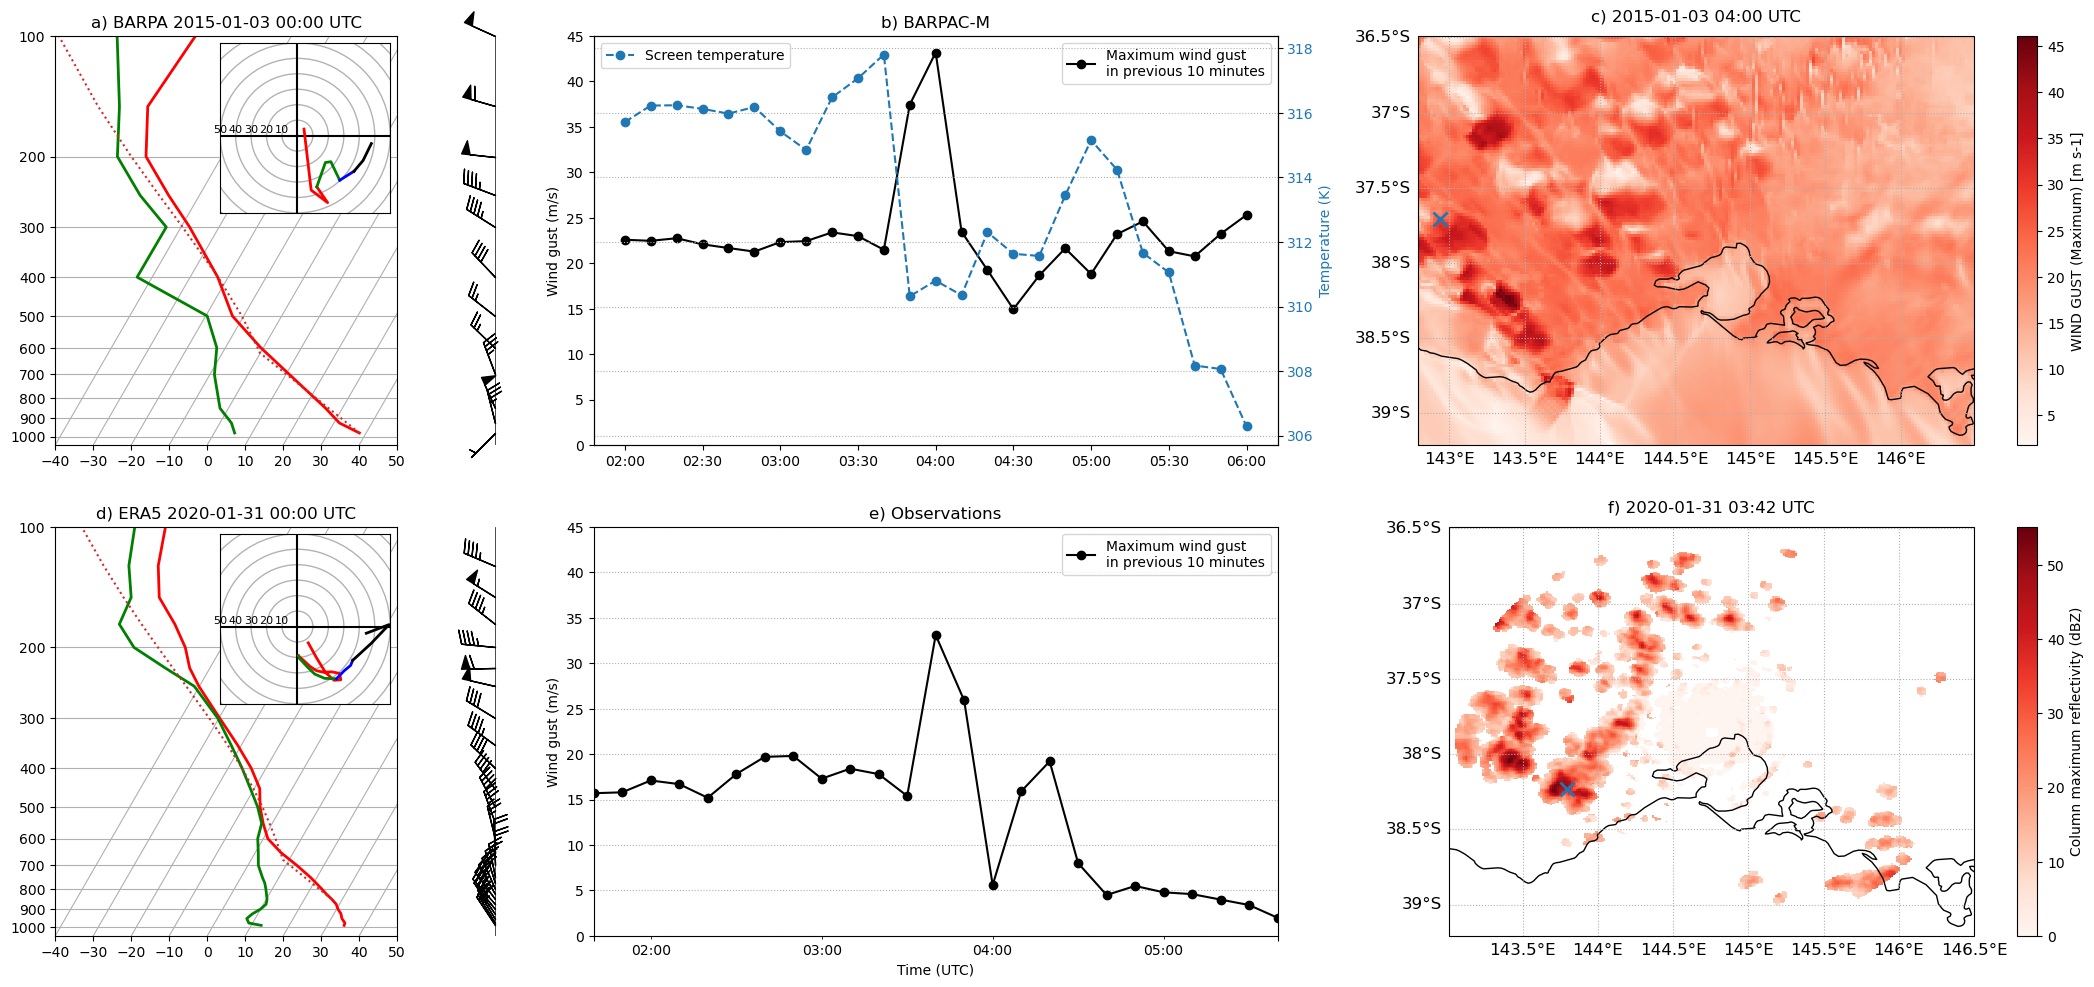

In [12]:
fig=plt.figure(figsize=[22,10])

#Plot the first cases
gs = fig.add_gridspec(2,4, width_ratios=[2,1,4,5])

#From BARPA
y,x=load_stn_info("vic").query("stn_no=="+"89112")[["lat","lon"]].values[0]    
prof, mu_pcl = plot_sounding_barpa(dt.datetime(2015,1,3,0,0),y,x)
ax = plt.subplot(gs[0, 0],projection='skewx')
ax2 = plt.subplot(gs[0, 1])
plot_prof(prof, ax, ax2, gs)
ax.set_title("a) BARPA 2015-01-03 00:00 UTC")

ax3=plt.subplot(gs[0, 2])
ax4=plt.subplot(gs[0, 3],projection=ccrs.PlateCarree())
plot_barpac_timeseries(ax3,ax4,dt.datetime(2015,1,3,4,0),"89112",y0=0,y1=45)
draw_gridlines(ax4)
ax3.set_title("b) BARPAC-M")
ax4.set_title("c) 2015-01-03 04:00 UTC")

#From ERA5
y,x=load_stn_info("vic").query("stn_no=="+"90035")[["lat","lon"]].values[0]    
print(x,y)

prof, mu_pcl = plot_sounding_era5(dt.datetime(2020,1,31,0,0),y,x)
ax = plt.subplot(gs[1, 0],projection='skewx')
ax2 = plt.subplot(gs[1, 1])
plot_prof(prof, ax, ax2, gs)
ax.set_title("d) ERA5 2020-01-31 00:00 UTC")

plot_obs_ts(plt.subplot(gs[1, 2]),dt.datetime(2020,1,31,3,42),"90035",y0=0,y1=45); plt.title("e) Observations")
ax5=plt.subplot(gs[1, 3],projection=ccrs.PlateCarree())
plot_radar(ax5,"2020-01-31 03:42","90035")
draw_gridlines(ax5)
ax5.set_title("f) 2020-01-31 03:42 UTC")
           
plt.savefig("/g/data/eg3/ab4502/figs/barpa/barpac_case_20150103.jpeg",dpi=400,bbox_inches="tight")


## Now do animations for each event

In [73]:
def load_barpac_anim(t,stn_id):

    
    #ax2=ax1.twinx()
    y,x=load_stn_info("vic").query("stn_no=="+stn_id)[["lat","lon"]].values[0]    
    temp = barpac_2p2km.query("stn_id=="+stn_id)
    temp = temp.set_index(pd.to_datetime(temp["Unnamed: 1"]))
    dg = temp.loc[slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=+2))]

    
    fs = scrn_temp = xr.open_mfdataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/era/erai/historical/r0/*/*/pp26/temp_scrn-pp26-BARPAC-M_km2p2-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=+2))).sel(longitude=x,latitude=y,method="nearest").temp_scrn
    

    
    fg = xr.open_mfdataset("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/era/erai/historical/r0/*/*/pp26/max_wndgust10m-pp26-BARPAC-M_km2p2-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=2))).sel(longitude=slice(142.8, 146.49597),latitude=slice(-39.204285, -36.494324)).\
            max_wndgust10m
    fu = xr.open_mfdataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/era/erai/historical/r0/*/*/pp26/uwnd10m-pp26-BARPAC-M_km2p2-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=2))).sel(longitude=slice(142.8, 146.49597),latitude=slice(-39.204285, -36.494324)).\
            uwnd10m
    fv = xr.open_mfdataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/era/erai/historical/r0/*/*/pp26/vwnd10m-pp26-BARPAC-M_km2p2-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=2))).sel(longitude=slice(142.8, 146.49597),latitude=slice(-39.204285, -36.494324)).\
            interp_like(fu).vwnd10m


    return dg, fs, fg, fu, fv, x, y

def load_barpar_anim(t,stn_id):

    
    fs = scrn_temp = xr.open_mfdataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/era/erai/historical/r0/*/*/pp26/temp_scrn-pp26-BARPA-EASTAUS_12km-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=+2))).sel(longitude=x,latitude=y,method="nearest").temp_scrn
    

    
    fg = xr.open_mfdataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/era/erai/historical/r0/*/*/pp26/wndgust10m-pp26-BARPA-EASTAUS_12km-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=2))).sel(longitude=slice(142.8, 146.49597),latitude=slice(-39.204285, -36.494324)).\
            wndgust10m
    fu = xr.open_mfdataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/era/erai/historical/r0/*/*/pp26/uwnd10m-pp26-BARPA-EASTAUS_12km-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=2))).sel(longitude=slice(142.8, 146.49597),latitude=slice(-39.204285, -36.494324)).\
            uwnd10m
    fv = xr.open_mfdataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/era/erai/historical/r0/*/*/pp26/vwnd10m-pp26-BARPA-EASTAUS_12km-"+t.strftime("%Y%m")+"*.nc").\
            sel(time=slice(t+dt.timedelta(hours=-2),t+dt.timedelta(hours=2))).sel(longitude=slice(142.8, 146.49597),latitude=slice(-39.204285, -36.494324)).\
            interp_like(fu).vwnd10m


    return dg, fs, fg, fu, fv, x, y

def plot_barpa_anim(t, dg, fs, fg, x, y, quiver=False, fu=None, fv=None, ts=True, ax3=None, coarsen=6):

    if ts:
        fig=plt.figure(figsize=[18,5])
        ax1=plt.subplot(1,2,1)
        ax2=ax1.twinx()
        ax3=plt.subplot(1,2,2,projection=ccrs.PlateCarree())

        ax1.plot(dg.index,dg["wg10_2p2km_point"].values,marker="o",color="k",label="Maximum wind gust\nin previous 10 minutes")
        ax1.set_ylim([0,45])
        ax1.set_title("BARPAC-M")

        ax2.plot(dg.index,fs.values,marker="o",color="tab:blue",ls="--",label="Screen temperature")
        ax2.legend(loc=2)
        ax1.legend(loc=1)

        ax1.axvline(t,ls=":",color="k")

        ax2.set_ylabel("Temperature (K)",color="tab:blue")
        ax1.set_ylabel("Wind gust (m/s)")
        ax2.tick_params(axis="y",labelcolor="tab:blue")
        ax2.grid(ls=":")
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
      
    
    fg.sel(time=t+dt.timedelta(minutes=5),method="nearest").plot(ax=ax3,vmin=0,vmax=45,cmap=plt.get_cmap("Reds"))
    ax3.coastlines()
    ax3.plot(x,y,marker="x",color="tab:blue",ms=10,mew=2)   
    
    if quiver:
        xr.Dataset({"u":fu,"v":fv}).\
            sel(time=t+dt.timedelta(minutes=5),method="nearest").\
            coarsen(dim={"longitude":coarsen,"latitude":coarsen},boundary="trim").mean().plot.quiver(
                x="longitude",y="latitude",u="u",v="v",ax=ax3,add_guide=False)        
    

In [50]:
gust_time = dt.datetime(2007,12,31,6,20)   
stn_id = "86371"

times = [gust_time + dt.timedelta(minutes=10*int(i)) for i in np.arange(-2*6,2*6+1)]
dg, fs, fg, fu, fv, x, y = load_barpac_anim(gust_time,stn_id)

for t in tqdm.tqdm(times):
    plot_barpa_anim(t, dg, fs, fg, x, y)
    plt.savefig("/scratch/eg3/ab4502/tmp/fig"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    
!convert -delay 50 -loop 0 /scratch/eg3/ab4502/tmp/fig*.png 20071231.gif
!rm /scratch/eg3/ab4502/tmp/fig*.png

100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


In [51]:
gust_time = dt.datetime(2015,1,3,4,0)
stn_id = "89112"

times = [gust_time + dt.timedelta(minutes=10*int(i)) for i in np.arange(-2*6,2*6+1)]
dg, fs, fg, fu, fv, x, y = load_barpac_anim(gust_time,stn_id)

for t in tqdm.tqdm(times):
    plot_barpa_anim(t, dg, fs, fg, x, y)
    plt.savefig("/scratch/eg3/ab4502/tmp/fig"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    
!convert -delay 50 -loop 0 /scratch/eg3/ab4502/tmp/fig*.png 20150103.gif
!rm /scratch/eg3/ab4502/tmp/fig*.png

100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


In [79]:
gust_time1 = dt.datetime(2007,12,31,6,20)   
stn_id1 = "86371"

gust_time2 = dt.datetime(2015,1,3,4,0)
stn_id2 = "89112"

times1 = [gust_time1 + dt.timedelta(minutes=10*int(i)) for i in np.arange(-2*6,2*6+1)]
dg1, fs1, fg1, fu1, fv1, x1, y1 = load_barpac_anim(gust_time1,stn_id1)
dg_r1, fs_r1, fg_r1, fu_r1, fv_r1, x_r1, y_r1 = load_barpar_anim(gust_time1,stn_id1)

times2 = [gust_time2 + dt.timedelta(minutes=10*int(i)) for i in np.arange(-2*6,2*6+1)]
dg2, fs2, fg2, fu2, fv2, x2, y2 = load_barpac_anim(gust_time2,stn_id2)
dg_r2, fs_r2, fg_r2, fu_r2, fv_r2, x_r2, y_r2 = load_barpar_anim(gust_time2,stn_id2)

for t1,t2 in tqdm.tqdm(zip(times1,times2)):
    fig=plt.figure(figsize=[18,12])  
    ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
    ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
    ax3=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
    ax4=plt.subplot(2,2,4,projection=ccrs.PlateCarree())    
    plot_barpa_anim(t1, dg1, fs1, fg1, x1, y1, quiver=True, fu=fu1, fv=fv1, ts=False, ax3=ax1)
    plot_barpa_anim(t1, dg_r1, fs_r1, fg_r1, x_r1, y_r1, quiver=True, fu=fu_r1, fv=fv_r1, ts=False, ax3=ax2,coarsen=1)    
    
    plot_barpa_anim(t2, dg2, fs2, fg2, x2, y2, quiver=True, fu=fu2, fv=fv2, ts=False, ax3=ax3)
    plot_barpa_anim(t2, dg_r2, fs_r2, fg_r2, x_r2, y_r2, quiver=True, fu=fu_r2, fv=fv_r2, ts=False, ax3=ax4,coarsen=1)        

    ax1.set_title("BARPAC-M " + t1.strftime("%Y-%m-%d %H:%M UTC"))
    ax2.set_title("BARPA-R " + t1.strftime("%Y-%m-%d %H:%M UTC"))
    ax3.set_title("BARPAC-M " + t2.strftime("%Y-%m-%d %H:%M UTC"))
    ax4.set_title("BARPA-R " + t2.strftime("%Y-%m-%d %H:%M UTC"))    
    
    plt.savefig("/scratch/eg3/ab4502/tmp/fig"+t1.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    
!convert -delay 50 -loop 0 /scratch/eg3/ab4502/tmp/fig*.png comparison.gif
!rm /scratch/eg3/ab4502/tmp/fig*.png



25it [00:36,  1.45s/it]


In [75]:
gust_time = dt.datetime(2007,12,31,6,20)   
stn_id = "86371"

times = [gust_time + dt.timedelta(minutes=10*int(i)) for i in np.arange(-2*6,2*6+1)]
dg, fs, fg, fu, fv, x, y = load_barpac_anim(gust_time,stn_id)
dg_r, fs_r, fg_r, fu_r, fv_r, x_r, y_r = load_barpar_anim(gust_time,stn_id)

for t in tqdm.tqdm(times):
    fig=plt.figure(figsize=[18,5])  
    plot_barpa_anim(t, dg, fs, fg, x, y, quiver=True, fu=fu, fv=fv, ts=False, ax3=plt.subplot(1,2,1,projection=ccrs.PlateCarree()))
    plot_barpa_anim(t, dg_r, fs_r, fg_r, x_r, y_r, quiver=True, fu=fu_r, fv=fv_r, ts=False, ax3=plt.subplot(1,2,2,projection=ccrs.PlateCarree()),coarsen=1)    
    plt.savefig("/scratch/eg3/ab4502/tmp/fig"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    
!convert -delay 50 -loop 0 /scratch/eg3/ab4502/tmp/fig*.png 20071231_quiver.gif
!rm /scratch/eg3/ab4502/tmp/fig*.png



100%|██████████| 25/25 [00:17<00:00,  1.43it/s]
